# NBRA-MD

In [1]:
!tar -xf res_ks_step2.tar.xz
!tar -xf res_sd_step3.tar.xz

In [1]:
import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
from libra_py import influence_spectrum as infsp
from libra_py import data_visualize
from libra_py import data_conv
import libra_py.workflows.nbra.step4 as step4
import libra_py.workflows.nbra.decoherence_times as decoherence_times
import libra_py.workflows.nbra.lz as lz
import libra_py.workflows.nbra.qsh as qsh
import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/cyberwksp21/Software/Conda/Miniconda3/envs/libra/lib/python3.6/import

In [2]:
help(step4.get_Hvib2)

Help on function get_Hvib2 in module libra_py.workflows.nbra.step4:

get_Hvib2(params)
    Reads several sets of vibronic Hamiltonian files 
    
    Args:
        params ( dictionary ): parameters controlling the function execution [Required!]
    
            Required parameter keys:
    
            * **params["data_set_paths"]** ( list of strings ):
                define the paths of the directories where the vibronic Hamiltonian files for
                different data sets (e.g. independent MD trajectories) are located. 
            .. note::
                In addition, requires parameters described in
                :func:`libra_py.workflows.nbra.step4.getHvib`
    
    Returns:
        list of lists of CMATRIX: Hvib: 
            the time series of Hvib matrices for several data sets, such that
            Hvib[idata][time] is a CMATRIX for the data set indexed by `idata`
            at time `time`
    
    Example:
        The full name of the vibronic Hamiltonian files rea

In [4]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_ks_step2/")

params["Hvib_re_prefix"] = "hvib_dia_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "hvib_dia_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 99
params["init_times"]     = [0]

params["nstates"]        = 172 # total number of electronic states
params["active_space"]   = list( range(params["nstates"]) ) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis
Length of hvib is:  99


In [5]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() function

print ( "\n Test, for energies, Ha ")
print ( "hvib[0][0].get(0,0) = ",  hvib[0][0].get(1,1) )
print ( "hvib[0][0].get(1,1) = ",  hvib[0][0].get(0,0) )

print ( "\n Test, for nacs, Ha ")
print ( "hvib[0][0].get(0,1) = ",  hvib[0][0].get(0,1) )
print ( "hvib[0][0].get(0,2) = ",  hvib[0][0].get(0,2) )



 Test, for energies, Ha 
hvib[0][0].get(0,0) =  (-0.18768502+0j)
hvib[0][0].get(1,1) =  (-0.19047019+0j)

 Test, for nacs, Ha 
hvib[0][0].get(0,1) =  -0.00010241917j
hvib[0][0].get(0,2) =  0.00026208738j


In [6]:
help(decoherence_times.energy_gaps_ave)

Help on function energy_gaps_ave in module libra_py.workflows.nbra.decoherence_times:

energy_gaps_ave(Hvib, itimes, nsteps)
    Pre-compute the energy gaps along the trajectory 
    
    Args:
        Hvib ( list of lists of CMATRIX objects ):
            Vibronic Hamiltonians along the trajectory for different data sets (adiabatic MDs),
            and potential different sections of the time-range
            where Hvib[idata][istep] is a CMATRIX object that represents a vibronic Hamiltonian
            from the data set ```idata``` at the time step ```istep```. 
    
        itimes ( list if ints ): initial times for averaging. The number ```itimes[idata]``` tells 
            which datapoint (timestep) of the time-series Hvib[idata] consider the beginning of 
            the range that will be used to compute gap fluctuations
    
        nsteps ( int ): the length of the time-steps to consider in the calculations for each data set
    
    Returns:
        ( list of MATRIX(nstate

<a name="decoherence_times_ave-1"></a>
Likewise, to compute the dephasing times, using the information on energy gap fluctuations, we use the function `decoherence_times.decoherence_times_ave`

In [7]:
help(decoherence_times.decoherence_times_ave)

Help on function decoherence_times_ave in module libra_py.workflows.nbra.decoherence_times:

decoherence_times_ave(Hvib, itimes, nsteps, verbosity=0)
    Compute the matrix of decoherence times from the time-series data 
    that consists of vereral data sets
    
    Ref: Akimov, A. V; Prezhdo O. V. J. Phys. Chem. Lett. 2013, 4, 3857  
    
    
    Args:
        Hvib ( list of lists of CMATRIX objects ):
            Vibronic Hamiltonians along the trajectory for different data sets (adiabatic MDs),
            and potential different sections of the time-range
            where Hvib[idata][istep] is a CMATRIX object that represents a vibronic Hamiltonian
            from the data set ```idata``` at the time step ```istep```. 
    
        itimes ( list if ints ): initial times for averaging. The number ```itimes[idata]``` tells 
            which datapoint (timestep) of the time-series Hvib[idata] consider the beginning of 
            the range that will be used to compute gap fluct

In [8]:
#params["init_times"] = [49]
#params["nsteps"] = 50

In [9]:
params["init_times"] = [0]
params["nsteps"] = 99

In [10]:
# Compute energy gaps and decoherence times over part of the trajectory we want. Using the init_times parameter
tau, rates = decoherence_times.decoherence_times_ave(hvib, [params["init_times"][0]], params["nsteps"], 0)
dE         = decoherence_times.energy_gaps_ave(      hvib, [params["init_times"][0]], params["nsteps"])
avg_deco   = tau * units.au2fs
print ("Finished gather data for MD time", params["nsteps"], "steps.")
print ("Dephasing time between Kohn-Sham orbitals 0 and 1 is:", tau.get(0,1) * units.au2fs, "fs")

Finished gather data for MD time 99 steps.
Dephasing time between Kohn-Sham orbitals 0 and 1 is: 28.81254976299527 fs


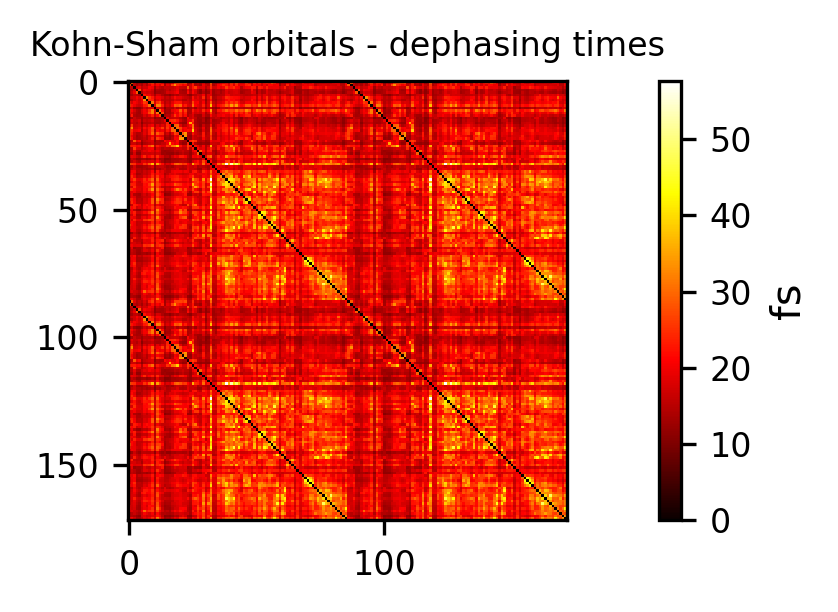

In [11]:
tau_kohn_sham = data_conv.MATRIX2nparray( tau ) * units.au2fs
for i in range( len(tau_kohn_sham) ):
    tau_kohn_sham[i][i] = 0.0
title_kohn_sham = "Kohn-Sham orbitals - dephasing times"
data = [tau_kohn_sham]
subplot_titles = [title_kohn_sham ]
data_visualize.plot_map_nparray( plt, data, fig_width=6.42, fig_height=2.14, titles=subplot_titles, \
                                 title_size=8, num_subplots=1, colormap='hot', \
                                 interpolation_scheme='nearest', colorbar_label='fs' )

In [13]:
print("\nGathering data from MD ")
print("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Slater determinant basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_sd_step3/")

params["Hvib_re_prefix"] = "Hvib_sorted_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "Hvib_sorted_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 99
params["init_times"]     = [0]

params["nstates"]        = 101 # total number of electronic states
params["active_space"]   = list( range(params["nstates"]) ) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib_sd = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Slater determinant basis
Length of hvib is:  99


In [14]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature

print( "\n Test, for energies, Ha ")
print( "hvib_sd[0][0].get(0,0) = ",  hvib_sd[0][0].get(1,1) )
print( "hvib_sd[0][0].get(1,1) = ",  hvib_sd[0][0].get(0,0) )

print( "\n Test, for nacs, Ha ")
print( "hvib_sd[0][0].get(0,1) = ",  hvib_sd[0][0].get(0,1) )
print( "hvib_sd[0][0].get(0,2) = ",  hvib_sd[0][0].get(0,2) )



 Test, for energies, Ha 
hvib_sd[0][0].get(0,0) =  -1.7385719e-05j
hvib_sd[0][0].get(1,1) =  (-1.0181838+0j)

 Test, for nacs, Ha 
hvib_sd[0][0].get(0,1) =  -1.3381727e-05j
hvib_sd[0][0].get(0,2) =  0.00024115064j


In [15]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature

print( "\n Test, for energies, eV ")
print( "hvib_sd[0][0].get(0,0) = ",  hvib_sd[0][0].get(1,1) * units.au2ev )
print( "hvib_sd[0][0].get(1,1) = ",  hvib_sd[0][0].get(0,0) * units.au2ev )

print( "\n Test, for nacs, eV ")
print( "hvib_sd[0][0].get(0,1) = ",  hvib_sd[0][0].get(0,1) * units.au2ev )
print( "hvib_sd[0][0].get(0,2) = ",  hvib_sd[0][0].get(0,2) * units.au2ev )


 Test, for energies, eV 
hvib_sd[0][0].get(0,0) =  -0.00047308279970899997j
hvib_sd[0][0].get(1,1) =  (-27.705799381800002+0j)

 Test, for nacs, eV 
hvib_sd[0][0].get(0,1) =  -0.000364130173397j
hvib_sd[0][0].get(0,2) =  0.00656195006504j


In [16]:
params["init_times"] = [49]
params["nsteps"] = 50
# Compute energy gaps and decoherence times over part of the trajectory we want
tau_sd, rates_sd = decoherence_times.decoherence_times_ave(hvib_sd, [params["init_times"][0]], params["nsteps"], 0)
dE_sd = decoherence_times.energy_gaps_ave(hvib_sd, [params["init_times"][0]], params["nsteps"])
avg_deco_sd = tau_sd * units.au2fs
print("Finished gather data for MD time", params["nsteps"], "steps.")
print("Dephasing time between states 0 and 1 is ", tau_sd.get(0,1) * units.au2fs)

Finished gather data for MD time 50 steps.
Dephasing time between states 0 and 1 is  5.124203730101109
